In [1]:
import numpy as np
import torch


import json
from torch.utils.data import DataLoader
from torch.optim import SGD, AdamW
from torch import nn

In [2]:
import utils_generic as generic
import rrnn_st as rrnn
import model_confs as confs

import singletask_dep as st
import train_dep as train

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
torch.manual_seed(27)

In [4]:
encoding_type = 'pos'

# Datos ConvAI2

In [5]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [6]:
vocab_dep = st.Vocabulary(data['train'],encoding_type)

In [7]:
convai_train = data['train']
convai_val = data['validation']


word_to_index = generic.create_word_to_index(convai_train)

convai_train_token = generic.tokenize_dataset_with_dependencies_rrnn(convai_train,['about','to','as'],vocab_dep,word_to_index) 
convai_val_token = generic.tokenize_dataset_with_dependencies_rrnn(convai_val,['about','to','as'],vocab_dep,word_to_index) 

In [8]:
convai_train_dataset = {}
for task in ['to','as','about']:
    convai_train_dataset[task] = rrnn.DatasetSingleTaskSimple(convai_train_token,task,eval=False,deps=True)

In [9]:
convai_val_dataset = {}
for task in ['to','as','about']:
    convai_val_dataset[task] = rrnn.DatasetSingleTaskSimple(convai_val_token,task,eval=False,deps=True)

# Datos md_gender

In [10]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [11]:
md_tokenized = generic.tokenize_dataset_with_dependencies_rrnn(md_data,['about','to','as'],vocab_dep,word_to_index) 


md_dataset = {}
for task in ['to','as','about']:
    md_dataset[task] = rrnn.DatasetSingleTaskSimple(md_tokenized,task,eval=True,deps=True)

# Creación dataloaders

In [12]:
dl_train = {}
for task in ['to','as','about']:
    dl_train[task] = DataLoader(convai_train_dataset[task],batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn_dep)

In [13]:
dl_val = {}
for task in ['to','as','about']:
    dl_val[task] = DataLoader(convai_val_dataset[task],batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn_dep)

In [14]:
dl_eval = {}
for task in ['to','as','about']:
    dl_eval[task] = DataLoader(md_dataset[task],batch_size=128,shuffle=False,collate_fn=rrnn.collate_fn_dep)

# ABOUT

In [15]:
emb_dim = 20
vocab_size = len(word_to_index)
num_labels = 2
lstm_hidden_dim = 128

In [16]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
save_path='m1_rrnn_dep_about_pos'

In [17]:
for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

GLOBAL: 0.5102040816326531 

Using scikit learn accuracy por género en el conjunto about
MALE 0.0
FEMALE 1.0 

GLOBAL: 0.4810606060606061 

Using scikit learn accuracy por género en el conjunto to
MALE 0.0
FEMALE 1.0 

GLOBAL: 0.48370273794002605 

Using scikit learn accuracy por género en el conjunto as
MALE 0.0
FEMALE 1.0 



  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6937209978336241 	 Validation loss: 0.6905998587608337 	 
  1%|          | 574/57400 [00:05<07:51, 120.48it/s]
Epoch 2 	 Training loss: 0.6882214720656232 	 Validation loss: 0.6871092299283561 	 
  2%|▏         | 1148/57400 [00:10<07:45, 120.77it/s]
Epoch 3 	 Training loss: 0.6851597125106572 	 Validation loss: 0.6855054396693989 	 
  3%|▎         | 1722/57400 [00:15<07:56, 116.86it/s]
Epoch 4 	 Training loss: 0.6834299761659177 	 Validation loss: 0.6845353306350062 	 
  4%|▍         | 2296/57400 [00:21<07:56, 115.67it/s]
Epoch 5 	 Training loss: 0.6824974818512123 	 Validation loss: 0.6839793688159878 	 
  5%|▌         | 2870/57400 [00:26<07:36, 119.43it/s]
Epoch 6 	 Training loss: 0.6819850425479304 	 Validation loss: 0.6840197716729116 	 
  6%|▌         | 3444/57400 [00:31<07:38, 117.65it/s]
Epoch 7 	 Training loss: 0.6816531892229871 	 Validation loss: 0.6839149563999499 	 
  7%|▋         | 4018/57400 [00:36<07:29, 118.83it/s]
Epoch 8 	 Training loss: 0.6

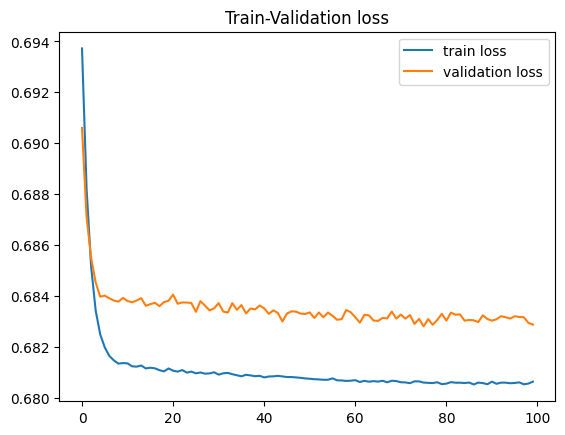

In [18]:
learning_rate = 5e-5
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path)

In [19]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))

for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

GLOBAL: 0.4897959183673469 

Using scikit learn accuracy por género en el conjunto about
MALE 1.0
FEMALE 0.0 

GLOBAL: 0.5189393939393939 

Using scikit learn accuracy por género en el conjunto to
MALE 1.0
FEMALE 0.0 

GLOBAL: 0.516297262059974 

Using scikit learn accuracy por género en el conjunto as
MALE 1.0
FEMALE 0.0 



# TO

In [20]:
emb_dim = 20
vocab_size = len(word_to_index)
num_labels = 2
lstm_hidden_dim = 128

In [21]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
save_path='m1_rrnn_dep_to_pos'

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6933088273536868 	 Validation loss: 0.6924414897369127 	 
  1%|          | 574/57400 [00:05<08:57, 105.75it/s]
Epoch 2 	 Training loss: 0.6931806994855196 	 Validation loss: 0.6922395421286761 	 
  2%|▏         | 1148/57400 [00:12<09:04, 103.30it/s]
Epoch 3 	 Training loss: 0.6932369217224653 	 Validation loss: 0.6923897215875529 	 
  3%|▎         | 1722/57400 [00:17<09:05, 102.11it/s]
Epoch 4 	 Training loss: 0.6931655906426366 	 Validation loss: 0.692623827417018 	 
  4%|▍         | 2296/57400 [00:23<08:44, 105.03it/s]
Epoch 5 	 Training loss: 0.6931236192116754 	 Validation loss: 0.6926793415667647 	 
  5%|▌         | 2870/57400 [00:29<08:42, 104.35it/s]
Epoch 6 	 Training loss: 0.6931472653295936 	 Validation loss: 0.6927602008237677 	 
  6%|▌         | 3444/57400 [00:35<08:36, 104.38it/s]
Epoch 7 	 Training loss: 0.6931548549530814 	 Validation loss: 0.6929216142428123 	 
  7%|▋         | 4018/57400 [00:41<08:26, 105.39it/s]
Epoch 8 	 Training loss: 0.69

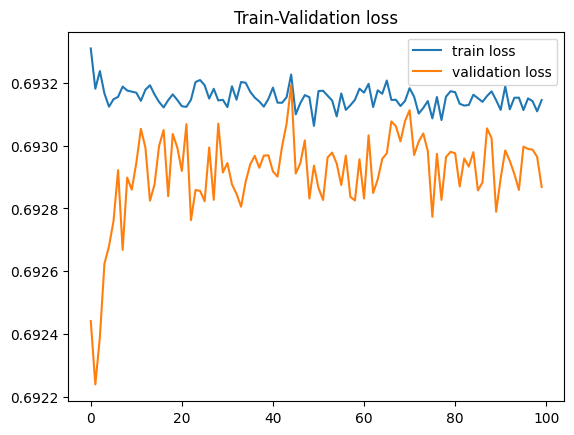

In [22]:
learning_rate = 5e-5
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path)

In [23]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))

for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

GLOBAL: 0.5153061224489796 

Using scikit learn accuracy por género en el conjunto about
MALE 0.041666666666666664
FEMALE 0.97 

GLOBAL: 0.47474747474747475 

Using scikit learn accuracy por género en el conjunto to
MALE 0.024330900243309004
FEMALE 0.9606299212598425 

GLOBAL: 0.48239895697522817 

Using scikit learn accuracy por género en el conjunto as
MALE 0.027777777777777776
FEMALE 0.967654986522911 



# AS

In [24]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
save_path='m1_rrnn_dep_as_pos'

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6937038173658923 	 Validation loss: 0.6949915683875649 	 
  1%|          | 574/57400 [00:06<09:08, 103.63it/s]
Epoch 2 	 Training loss: 0.6935137660868907 	 Validation loss: 0.693781367803024 	 
  2%|▏         | 1148/57400 [00:11<08:44, 107.19it/s]
Epoch 3 	 Training loss: 0.6933126970866 	 Validation loss: 0.6937583856663462 	 
  3%|▎         | 1722/57400 [00:17<08:53, 104.28it/s]
Epoch 4 	 Training loss: 0.6932301588797819 	 Validation loss: 0.6934703638998129 	 
  4%|▍         | 2296/57400 [00:23<08:44, 104.98it/s]
Epoch 5 	 Training loss: 0.6932056894078072 	 Validation loss: 0.6932956879421815 	 
  5%|▌         | 2870/57400 [00:29<08:50, 102.83it/s]
Epoch 6 	 Training loss: 0.6931185219761387 	 Validation loss: 0.6933295645956266 	 
  6%|▌         | 3444/57400 [00:35<08:28, 106.12it/s]
Epoch 7 	 Training loss: 0.69312856618951 	 Validation loss: 0.6933047670429036 	 
  7%|▋         | 4018/57400 [00:41<08:15, 107.79it/s]
Epoch 8 	 Training loss: 0.6931164

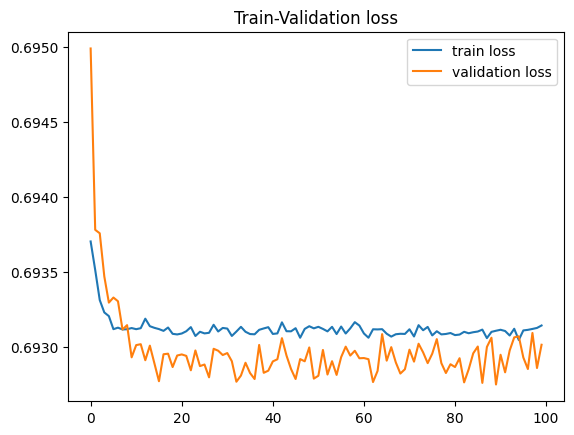

In [25]:
learning_rate = 5e-5
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path)

In [26]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))

for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

GLOBAL: 0.4770408163265306 

Using scikit learn accuracy por género en el conjunto about
MALE 0.4244791666666667
FEMALE 0.5275 

GLOBAL: 0.51010101010101 

Using scikit learn accuracy por género en el conjunto to
MALE 0.45742092457420924
FEMALE 0.5669291338582677 

GLOBAL: 0.4706649282920469 

Using scikit learn accuracy por género en el conjunto as
MALE 0.4166666666666667
FEMALE 0.5283018867924528 



# ADAM

In [27]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
save_path='m1_rrnn_dep_about_pos_adam'

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6756393146224138 	 Validation loss: 0.6644644080582311 	 
  1%|          | 574/57400 [00:10<15:44, 60.18it/s]
Epoch 2 	 Training loss: 0.6537752916796282 	 Validation loss: 0.6555918626866098 	 
  2%|▏         | 1148/57400 [00:20<15:44, 59.53it/s]
Epoch 3 	 Training loss: 0.6447987358121506 	 Validation loss: 0.6466409513505839 	 
  3%|▎         | 1722/57400 [00:30<15:36, 59.44it/s]
Epoch 4 	 Training loss: 0.6375636516547785 	 Validation loss: 0.6395254892817999 	 
  4%|▍         | 2296/57400 [00:40<15:32, 59.11it/s]
Epoch 5 	 Training loss: 0.6307847676376848 	 Validation loss: 0.6339069857435712 	 
  5%|▌         | 2870/57400 [00:50<15:00, 60.53it/s]
Epoch 6 	 Training loss: 0.624469508692778 	 Validation loss: 0.629035491054341 	 
  6%|▌         | 3444/57400 [01:02<15:20, 58.59it/s]
Epoch 7 	 Training loss: 0.6176272119794574 	 Validation loss: 0.6220627669560708 	 
  7%|▋         | 4018/57400 [01:12<15:28, 57.47it/s]
Epoch 8 	 Training loss: 0.6110515659

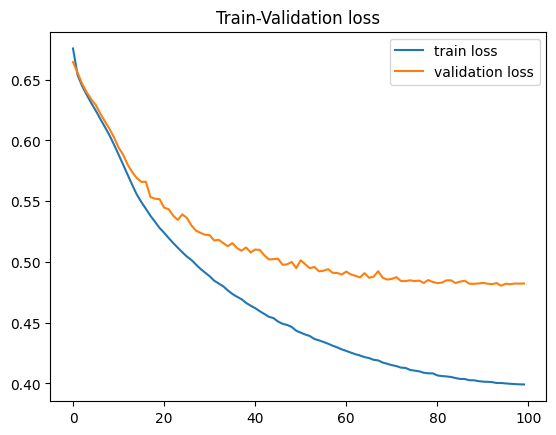

In [28]:
learning_rate = 5e-5
optimizer = AdamW(model.parameters(), lr=learning_rate)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path)

In [29]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))

for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

GLOBAL: 0.7040816326530612 

Using scikit learn accuracy por género en el conjunto about
MALE 0.8020833333333334
FEMALE 0.61 

GLOBAL: 0.5618686868686869 

Using scikit learn accuracy por género en el conjunto to
MALE 0.6642335766423357
FEMALE 0.45144356955380577 

GLOBAL: 0.5840938722294654 

Using scikit learn accuracy por género en el conjunto as
MALE 0.6818181818181818
FEMALE 0.4797843665768194 



# TO

In [30]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
save_path='m1_rrnn_dep_to_pos_adam'

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6933274400981877 	 Validation loss: 0.692278000257783 	 
  1%|          | 574/57400 [00:11<19:26, 48.73it/s]
Epoch 2 	 Training loss: 0.6931936273591444 	 Validation loss: 0.6928132833060572 	 
  2%|▏         | 1148/57400 [00:22<16:31, 56.73it/s]
Epoch 3 	 Training loss: 0.6930964804069506 	 Validation loss: 0.6921105980873108 	 
  3%|▎         | 1722/57400 [00:31<10:59, 84.46it/s]
Epoch 4 	 Training loss: 0.693160804618111 	 Validation loss: 0.6932454159704305 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [00:39<11:48, 77.72it/s]
Epoch 5 	 Training loss: 0.693043767263665 	 Validation loss: 0.693148093708491 	 

2 epoch without improvement
  5%|▌         | 2870/57400 [00:47<11:47, 77.05it/s]
Epoch 6 	 Training loss: 0.6930801470728286 	 Validation loss: 0.6924954238584486 	 
  6%|▌         | 3444/57400 [00:55<11:44, 76.59it/s]
Epoch 7 	 Training loss: 0.6930101262567766 	 Validation loss: 0.6941466846708524 	 

3 epoch without improvement
  7%|

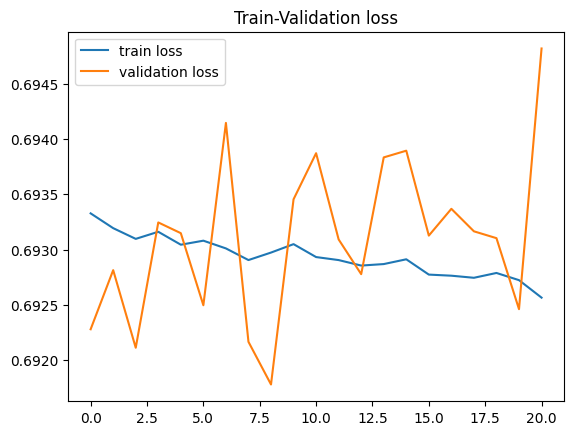

In [31]:
learning_rate = 5e-5
optimizer = AdamW(model.parameters(), lr=learning_rate)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path)

In [32]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))

for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

GLOBAL: 0.5102040816326531 

Using scikit learn accuracy por género en el conjunto about
MALE 0.028645833333333332
FEMALE 0.9725 

GLOBAL: 0.4722222222222222 

Using scikit learn accuracy por género en el conjunto to
MALE 0.0170316301703163
FEMALE 0.963254593175853 

GLOBAL: 0.4863102998696219 

Using scikit learn accuracy por género en el conjunto as
MALE 0.020202020202020204
FEMALE 0.9838274932614556 



# AS

In [33]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
save_path='m1_rrnn_dep_as_pos_adam'

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6933236061903658 	 Validation loss: 0.69261330164085 	 
  1%|          | 574/57400 [00:08<13:32, 69.90it/s]
Epoch 2 	 Training loss: 0.6931918501230898 	 Validation loss: 0.6936766242576857 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:16<12:06, 77.44it/s]
Epoch 3 	 Training loss: 0.6931370823848538 	 Validation loss: 0.692724552194951 	 
  3%|▎         | 1722/57400 [00:24<12:07, 76.58it/s]
Epoch 4 	 Training loss: 0.6930712712766401 	 Validation loss: 0.6927891363531856 	 
  4%|▍         | 2296/57400 [00:32<12:15, 74.95it/s]
Epoch 5 	 Training loss: 0.6931258018423871 	 Validation loss: 0.6929632506128085 	 
  5%|▌         | 2870/57400 [00:41<12:23, 73.35it/s]
Epoch 6 	 Training loss: 0.6931211395961482 	 Validation loss: 0.6932328333288936 	 
  6%|▌         | 3444/57400 [00:49<11:53, 75.62it/s]
Epoch 7 	 Training loss: 0.6930367995429952 	 Validation loss: 0.6927841507782371 	 
  7%|▋         | 4018/57400 [00:57<11:45, 75.65it/s]
Epoch 8 	

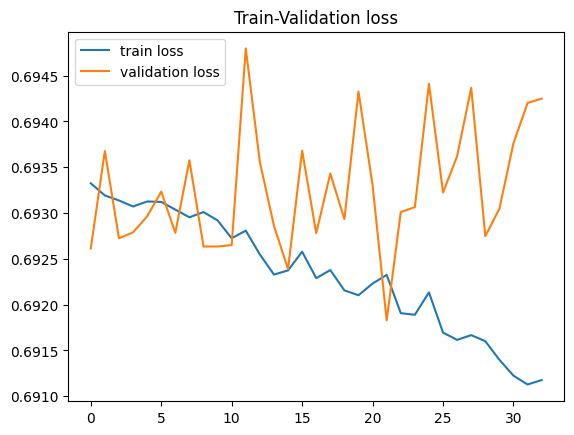

In [34]:
learning_rate = 5e-5
optimizer = AdamW(model.parameters(), lr=learning_rate)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path)

In [35]:
model = rrnn.SingleTaskRRNNDep(emb_dim,vocab_dep,vocab_size,lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))

for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

GLOBAL: 0.46811224489795916 

Using scikit learn accuracy por género en el conjunto about
MALE 0.23958333333333334
FEMALE 0.6875 

GLOBAL: 0.4898989898989899 

Using scikit learn accuracy por género en el conjunto to
MALE 0.22141119221411193
FEMALE 0.7795275590551181 

GLOBAL: 0.5319426336375489 

Using scikit learn accuracy por género en el conjunto as
MALE 0.28535353535353536
FEMALE 0.7951482479784366 

